**Import necessary packages for data analysis and study**

In [1]:
import numpy as np # linear algebra
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import lightgbm as lgb
import gc
from sklearn.metrics import roc_auc_score,mean_squared_error
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('max_columns',40 )

!pip install category-encoders


import re
import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
./__notebook_source__.ipynb


In [2]:
raw_listings = pd.read_csv("./listings.csv")

In [3]:
cols_to_drop = list( raw_listings.columns[raw_listings.isnull().sum(axis=0)==raw_listings.shape[0]] ) + ['scrape_id']
drop_columns = ['listing_url','last_scraped','name','description', 'neighborhood_overview','host_url', \
                'host_thumbnail_url', 'picture_url', 'host_picture_url', 'neighbourhood_cleansed',\
                'host_id', 'host_name','host_location','host_about','host_total_listings_count',\
               'latitude', 'longitude','first_review','last_review','host_listings_count','host_since',\
               'calendar_last_scraped','host_neighbourhood','neighbourhood',\
               'minimum_minimum_nights', 'maximum_minimum_nights','minimum_maximum_nights', 'maximum_maximum_nights',\
               'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability', 'availability_30', \
                'availability_60', 'availability_90', 'availability_365', 'host_verifications']

drop_columns = cols_to_drop + drop_columns

In [4]:
data_time_stamp = pd.Timestamp('2020-10-24')
raw_listings['host_years'] = ( data_time_stamp - pd.to_datetime(raw_listings['host_since']) ).astype('<m8[Y]')
raw_listings['utilization_rate'] = 1 - raw_listings['availability_365']/365
raw_listings.head(3)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,...,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_years,utilization_rate
0,3781,https://www.airbnb.com/rooms/3781,20201024170420,2020-10-24,HARBORSIDE-Walk to subway,Fully separate apartment in a two apartment bu...,"Mostly quiet ( no loud music, no crowed sidewa...",https://a0.muscache.com/pictures/24670/b2de044...,4804,https://www.airbnb.com/users/show/4804,Frank,2008-12-03,Massachusetts,My wife and I and grown children frequently oc...,within a day,90%,29%,f,https://a0.muscache.com/im/users/4804/profile_...,https://a0.muscache.com/im/users/4804/profile_...,...,2,0,2015-07-10,2020-09-03,99.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,f,1,1,0,0,0.26,11.0,0.663014
1,5506,https://www.airbnb.com/rooms/5506,20201024170420,2020-10-24,**$49 Special ** Private! Minutes to center!,"Private guest room with private bath, You do n...","Peacful, Architecturally interesting, historic...",https://a0.muscache.com/pictures/1598e8b6-5a55...,8229,https://www.airbnb.com/users/show/8229,Terry,2009-02-19,"Boston, Massachusetts, United States","Relaxed, Easy going, Accommodating.",within an hour,100%,100%,t,https://a0.muscache.com/im/users/8229/profile_...,https://a0.muscache.com/im/users/8229/profile_...,...,2,0,2009-03-21,2020-05-01,95.0,10.0,10.0,10.0,10.0,9.0,10.0,Exempt: This listing is a unit that has contra...,f,6,6,0,0,0.76,11.0,1.000000
2,6695,https://www.airbnb.com/rooms/6695,20201024170420,2020-10-24,$99 Special!! Home Away! Condo,"Comfortable, Fully Equipped private apartment...","Peaceful, Architecturally interesting, histori...",https://a0.muscache.com/pictures/38ac4797-e7a4...,8229,https://www.airbnb.com/users/show/8229,Terry,2009-02-19,"Boston, Massachusetts, United States","Relaxed, Easy going, Accommodating.",within an hour,100%,100%,t,https://a0.muscache.com/im/users/8229/profile_...,https://a0.muscache.com/im/users/8229/profile_...,...,2,0,2009-08-06,2019-11-02,96.0,10.0,10.0,10.0,10.0,9.0,10.0,STR-404620,f,6,6,0,0,0.84,11.0,1.000000


In [5]:
proc_listings = raw_listings.drop(labels=drop_columns, axis=1)

In [6]:
def data_proc(df):
    """
    1. Process binary features
    2. License is process as a binary feature in this study
    3. Some numerical features have NaN values and they are replaced with 0
    4. Convert host_acceptance_rate, host_response_rate, price from string to float nubmers
    5. Add some amenties as binary features, including wifi, kitchen, washer, and dryer
    """
    
    binary_attr = ['host_is_superhost', 'host_has_profile_pic','host_identity_verified','instant_bookable']
    null_attr = ['license']
    cat_attr = ['property_type', 'room_type', 'bathrooms_text','host_response_time']
    fill_zero_atrr = ['bedrooms', 'beds','number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',\
                 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms',\
                   'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'host_years']
    
    
    for attr in binary_attr:
        df[attr] = df.apply(lambda x:0 if x[attr]=='f' else 1, axis=1)

    for attr in null_attr:
        df[[attr]] = df[[attr]].where(df[[attr]].isnull(), 1).fillna(0).astype(int)

    for attr in fill_zero_atrr:
        df[attr].fillna(0, inplace=True)
        
    def p2f(x):
        if type(x) == str:
            return float(x.strip('%'))/100
        else:
            return x

    df['host_acceptance_rate'] = df['host_acceptance_rate'].apply( p2f)
    df['host_response_rate'] = df['host_response_rate'].apply(p2f)
    
    def dollar2f(x):
        if type(x) == str:
            return float(re.sub('[\$,]', '', x))
        else:
            return x

    df['price'] = df['price'].apply( dollar2f)
    
    def chkin(x, name):
        if name in x.lower():
            return 1
        else:
            0
    amenities_list = ['wifi','kitchen','washer','dryer']
    for attr in amenities_list:
        df[attr] = df['amenities'].apply(chkin, name=attr)
        df[attr].fillna(0, inplace=True)
    
    return df

In [7]:
proc_lists = data_proc(proc_listings)
# Some Airbnb has no availability at all and those properties would be discarded for this tudy
proc_lists_rmout = proc_lists.loc[ (proc_lists.utilization_rate<1) ]

In [8]:
fnlattr = ['host_acceptance_rate', 'host_is_superhost','host_response_time', 'host_response_rate',
       'host_has_profile_pic', 'host_identity_verified', 'property_type',
       'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds',
       'price', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'license',
       'instant_bookable', 'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
       'host_years', 'wifi', 'kitchen', 'washer', 'dryer']
x_proc = proc_lists_rmout[fnlattr]
y_proc = proc_lists_rmout['utilization_rate']
print ("final proccessed data shape", x_proc.shape, y_proc.shape)

final proccessed data shape (2679, 37) (2679,)


In [9]:
# https://www.kaggle.com/garethjns/titanicsexism-fairness-in-ml
# Customized LabelEnocder to handle unknow values
class LabelEncoder(TransformerMixin):
    """Convert non-numeric columns to numeric using label encoding. 
    Handles unseen data on transform."""
    def fit(self, x: pd.DataFrame) -> "LabelEncoder":
        """Learn encoder for each column."""
        encoders = {}
        for c in x:
            # Make encoder using pd.factorize on unique values, 
            # then convert to a dictionary
            v, k = zip(pd.factorize(x[c].unique()))
            encoders[c] = dict(zip(k[0], v[0]))

        self.encoders_ = encoders

        return self

    def transform(self, x) -> pd.DataFrame:
        """For columns in x that have learned encoders, apply encoding."""
        x = x.copy()
        for c in x:
            # Ignore new, unseen values
            x.loc[~x[c].isin(self.encoders_[c]), c] = np.nan
            # Map learned labels
            x.loc[:, c] = x[c].map(self.encoders_[c])

        # Return without nans
        return x.fillna(-2).astype(int)

x_train, x_test, y_train, y_test = train_test_split(x_proc,y_proc, test_size=0.2, random_state=36)

In [10]:
def data_ss(x_train, x_test):
    """
    1. For dense features, first fill NaN with median
    2. Use customized LabelEncoder to encode categorical features
    3. Use OrdinalEncoder to encode ordinal features
    """
    
    dense_attr = ['host_acceptance_rate','host_response_rate', 'minimum_nights', 'maximum_nights', 'review_scores_rating', 'number_of_reviews','number_of_reviews_ltm',\
                'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin','price', 'host_years','reviews_per_month',\
                'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'number_of_reviews_l30d',\
              'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms',  'calculated_host_listings_count_shared_rooms',\
             'accommodates',  'bedrooms', 'beds']
    cat_attr_needlabel = ['property_type', 'room_type']
    ord_attr_needlabel = ['host_response_time', 'bathrooms_text']
    
    ss_dict = {}
    median_dict = {}
    x_train_copy = x_train.copy()
    for col in dense_attr:
    #     print (col)
        median_dict[col] = np.nanmedian(x_train.loc[:, col])
        x_train.loc[:,col].fillna(median_dict[col], inplace=True)
        x_test.loc[:,col].fillna(median_dict[col], inplace=True)

        ss = StandardScaler()
        ss.fit(x_train_copy.loc[:, col].values[:,None])

        ss_dict[col] = ss
        x_train.loc[:, col] =  ss.transform(x_train.loc[:,col].values[:,None] ) 
        x_test.loc[:, col] = ss.transform(x_test.loc[:,col].values[:,None] )
        
    le = LabelEncoder()
    x_train[ cat_attr_needlabel ] = le.fit_transform(x_train[ cat_attr_needlabel ])
    x_test[ cat_attr_needlabel ] = le.transform(x_test[ cat_attr_needlabel ])
    
    oe = OrdinalEncoder(handle_unknown='value')
    x_train[ ord_attr_needlabel ] = le.fit_transform(x_train[ ord_attr_needlabel ])
    x_test[ ord_attr_needlabel ] = le.transform(x_test[ ord_attr_needlabel ])

    return x_train, x_test

In [11]:
#  gradient boosting parameters
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l2', 'auc'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 256,  
    "max_bin": 63,
    "num_iterations": 100000,
    "n_estimators": 1000
}


In [12]:
# 10 folds cross-validation

NFOLDS = 10

folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=36)

columns = x_proc.columns
splits = folds.split(x_proc, y_proc)

y_oof = np.zeros(x_proc.shape[0])

score = 0

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    x_train, x_valid = x_proc[columns].iloc[train_index], x_proc[columns].iloc[valid_index]
    y_train, y_valid = y_proc.iloc[train_index], y_proc.iloc[valid_index]
    
   
    x_train_ss, x_valid_ss = data_ss(x_train.copy(), x_valid.copy())
    


    clf = lgb.LGBMRegressor(**hyper_params)
    clf.fit(x_train_ss, y_train, eval_set = [(x_valid_ss, y_valid)], eval_metric='l1', verbose = 200, early_stopping_rounds=1000)

    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importances_
    
    y_pred_valid = clf.predict(x_valid_ss, num_iteration=clf.best_iteration_)
    y_oof[valid_index] = y_pred_valid
    
    print(f"Fold {fold_n + 1} | AUC: {mean_squared_error(y_valid, y_pred_valid)}")
    
    score += mean_squared_error(y_valid, y_pred_valid) / NFOLDS

    del x_train, x_valid, y_train, y_valid
    gc.collect()
    
print(f"\nMean Mean squared error = {score}")
# print (y_proc.shape, y_oof.shape)
print(f"Out of folds Mean squared error = {mean_squared_error(y_proc, y_oof)}")

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 1000 rounds
[200]	valid_0's l1: 0.226747	valid_0's l2: 0.0684622	valid_0's auc: 0.715226
[400]	valid_0's l1: 0.203729	valid_0's l2: 0.0619852	valid_0's auc: 0.724774
[600]	valid_0's l1: 0.194541	valid_0's l2: 0.0601127	valid_0's auc: 0.730041
[800]	valid_0's l1: 0.188663	valid_0's l2: 0.0583213	valid_0's auc: 0.732675
[1000]	valid_0's l1: 0.186511	valid_0's l2: 0.0582099	valid_0's auc: 0.732016
[1200]	valid_0's l1: 0.183576	valid_0's l2: 0.0572767	valid_0's auc: 0.735473
[1400]	valid_0's l1: 0.182886	valid_0's l2: 0.0574968	valid_0's auc: 0.736461
[1600]	valid_0's l1: 0.181852	valid_0's l2: 0.0573644	valid_0's auc: 0.738765
[1800]	valid_0's l1: 0.181488	valid_0's l2: 0.0576111	valid_0's auc: 0.736955
[2000]	valid_0's l1: 0.181769	valid_0's l2: 0.0580681	valid_0's auc: 0.735802
[2200]	valid_0's l1: 0.180968	valid_0's l2: 0.0579741	valid_0's auc: 0.738436
Early stopping, best iteration is:
[1278]	valid_0's l1: 0.182969	valid_0's l2: 0.05

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 1000 rounds
[200]	valid_0's l1: 0.228582	valid_0's l2: 0.0701812	valid_0's auc: 0.749815
[400]	valid_0's l1: 0.205806	valid_0's l2: 0.0626842	valid_0's auc: 0.759054
[600]	valid_0's l1: 0.196563	valid_0's l2: 0.0596081	valid_0's auc: 0.766999
[800]	valid_0's l1: 0.191846	valid_0's l2: 0.057971	valid_0's auc: 0.771434
[1000]	valid_0's l1: 0.188253	valid_0's l2: 0.0567579	valid_0's auc: 0.775868
[1200]	valid_0's l1: 0.186774	valid_0's l2: 0.0563308	valid_0's auc: 0.777531
[1400]	valid_0's l1: 0.184825	valid_0's l2: 0.0557567	valid_0's auc: 0.781412
[1600]	valid_0's l1: 0.183588	valid_0's l2: 0.0555447	valid_0's auc: 0.786031
[1800]	valid_0's l1: 0.183024	valid_0's l2: 0.0555391	valid_0's auc: 0.788433
[2000]	valid_0's l1: 0.181933	valid_0's l2: 0.0553565	valid_0's auc: 0.791944
[2200]	valid_0's l1: 0.180426	valid_0's l2: 0.0548897	valid_0's auc: 0.792129
[2400]	valid_0's l1: 0.179238	valid_0's l2: 0.0545567	valid_0's auc: 0.798226
[2600]

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 1000 rounds
[200]	valid_0's l1: 0.231275	valid_0's l2: 0.0710668	valid_0's auc: 0.63627
[400]	valid_0's l1: 0.211203	valid_0's l2: 0.0658943	valid_0's auc: 0.64959
[600]	valid_0's l1: 0.204457	valid_0's l2: 0.0651039	valid_0's auc: 0.647541
[800]	valid_0's l1: 0.200819	valid_0's l2: 0.064634	valid_0's auc: 0.653518
[1000]	valid_0's l1: 0.198304	valid_0's l2: 0.0642511	valid_0's auc: 0.655055
[1200]	valid_0's l1: 0.196356	valid_0's l2: 0.0640743	valid_0's auc: 0.653859
[1400]	valid_0's l1: 0.196429	valid_0's l2: 0.06472	valid_0's auc: 0.658128
[1600]	valid_0's l1: 0.195357	valid_0's l2: 0.0645694	valid_0's auc: 0.659836
[1800]	valid_0's l1: 0.194652	valid_0's l2: 0.0648438	valid_0's auc: 0.659153
[2000]	valid_0's l1: 0.193495	valid_0's l2: 0.0647029	valid_0's auc: 0.659324
Early stopping, best iteration is:
[1167]	valid_0's l1: 0.19642	valid_0's l2: 0.0639279	valid_0's auc: 0.654884
Fold 3 | AUC: 0.06392794508114462


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 1000 rounds
[200]	valid_0's l1: 0.224851	valid_0's l2: 0.0712173	valid_0's auc: 0.699301
[400]	valid_0's l1: 0.199694	valid_0's l2: 0.0637603	valid_0's auc: 0.707406
[600]	valid_0's l1: 0.19021	valid_0's l2: 0.0611839	valid_0's auc: 0.709472
[800]	valid_0's l1: 0.186356	valid_0's l2: 0.060432	valid_0's auc: 0.70089
[1000]	valid_0's l1: 0.18286	valid_0's l2: 0.0596296	valid_0's auc: 0.704228
Early stopping, best iteration is:
[61]	valid_0's l1: 0.266682	valid_0's l2: 0.0885033	valid_0's auc: 0.725445
Fold 4 | AUC: 0.08850325904275372


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 1000 rounds
[200]	valid_0's l1: 0.236782	valid_0's l2: 0.0747564	valid_0's auc: 0.699424
[400]	valid_0's l1: 0.212792	valid_0's l2: 0.0664507	valid_0's auc: 0.710617
[600]	valid_0's l1: 0.201989	valid_0's l2: 0.0631251	valid_0's auc: 0.718189
[800]	valid_0's l1: 0.196377	valid_0's l2: 0.0615346	valid_0's auc: 0.722305
[1000]	valid_0's l1: 0.191987	valid_0's l2: 0.0601799	valid_0's auc: 0.718354
[1200]	valid_0's l1: 0.188582	valid_0's l2: 0.0592396	valid_0's auc: 0.721646
[1400]	valid_0's l1: 0.186462	valid_0's l2: 0.0590968	valid_0's auc: 0.722634
[1600]	valid_0's l1: 0.184758	valid_0's l2: 0.0586121	valid_0's auc: 0.72856
[1800]	valid_0's l1: 0.183233	valid_0's l2: 0.0583273	valid_0's auc: 0.734321
[2000]	valid_0's l1: 0.182008	valid_0's l2: 0.058362	valid_0's auc: 0.734486
[2200]	valid_0's l1: 0.181101	valid_0's l2: 0.0581571	valid_0's auc: 0.736461
[2400]	valid_0's l1: 0.18052	valid_0's l2: 0.0581804	valid_0's auc: 0.736626
[2600]	v

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 1000 rounds
[200]	valid_0's l1: 0.221414	valid_0's l2: 0.0692101	valid_0's auc: 0.812725
[400]	valid_0's l1: 0.200271	valid_0's l2: 0.062303	valid_0's auc: 0.819277
[600]	valid_0's l1: 0.193394	valid_0's l2: 0.0615438	valid_0's auc: 0.819066
[800]	valid_0's l1: 0.191044	valid_0's l2: 0.0614077	valid_0's auc: 0.823082
[1000]	valid_0's l1: 0.189051	valid_0's l2: 0.0611912	valid_0's auc: 0.829212
[1200]	valid_0's l1: 0.187678	valid_0's l2: 0.060978	valid_0's auc: 0.834496
[1400]	valid_0's l1: 0.186948	valid_0's l2: 0.0612841	valid_0's auc: 0.838301
[1600]	valid_0's l1: 0.186426	valid_0's l2: 0.0614149	valid_0's auc: 0.843585
[1800]	valid_0's l1: 0.186639	valid_0's l2: 0.0619918	valid_0's auc: 0.844853
[2000]	valid_0's l1: 0.186492	valid_0's l2: 0.0621209	valid_0's auc: 0.848658
Early stopping, best iteration is:
[1079]	valid_0's l1: 0.188053	valid_0's l2: 0.0608838	valid_0's auc: 0.832171
Fold 6 | AUC: 0.06088383101871146


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 1000 rounds
[200]	valid_0's l1: 0.230558	valid_0's l2: 0.0717655	valid_0's auc: 0.678083
[400]	valid_0's l1: 0.208051	valid_0's l2: 0.0646554	valid_0's auc: 0.688021
[600]	valid_0's l1: 0.199307	valid_0's l2: 0.0617168	valid_0's auc: 0.694942
[800]	valid_0's l1: 0.194422	valid_0's l2: 0.0600653	valid_0's auc: 0.700444
[1000]	valid_0's l1: 0.191122	valid_0's l2: 0.0589003	valid_0's auc: 0.701863
[1200]	valid_0's l1: 0.188252	valid_0's l2: 0.0577638	valid_0's auc: 0.704348
[1400]	valid_0's l1: 0.186075	valid_0's l2: 0.057078	valid_0's auc: 0.702751
[1600]	valid_0's l1: 0.184589	valid_0's l2: 0.056907	valid_0's auc: 0.70417
[1800]	valid_0's l1: 0.183778	valid_0's l2: 0.0567637	valid_0's auc: 0.701686
[2000]	valid_0's l1: 0.183292	valid_0's l2: 0.0566877	valid_0's auc: 0.707187
[2200]	valid_0's l1: 0.182141	valid_0's l2: 0.056396	valid_0's auc: 0.705768
[2400]	valid_0's l1: 0.181351	valid_0's l2: 0.0562331	valid_0's auc: 0.708607
[2600]	va

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 1000 rounds
[200]	valid_0's l1: 0.220496	valid_0's l2: 0.0644417	valid_0's auc: 0.737103
[400]	valid_0's l1: 0.201928	valid_0's l2: 0.0579431	valid_0's auc: 0.757688
[600]	valid_0's l1: 0.194396	valid_0's l2: 0.0554322	valid_0's auc: 0.763145
[800]	valid_0's l1: 0.189933	valid_0's l2: 0.0544159	valid_0's auc: 0.773562
[1000]	valid_0's l1: 0.186919	valid_0's l2: 0.0538846	valid_0's auc: 0.772817
[1200]	valid_0's l1: 0.184201	valid_0's l2: 0.0534587	valid_0's auc: 0.772817
[1400]	valid_0's l1: 0.18376	valid_0's l2: 0.0534411	valid_0's auc: 0.776538
[1600]	valid_0's l1: 0.183159	valid_0's l2: 0.0536199	valid_0's auc: 0.776042
[1800]	valid_0's l1: 0.182441	valid_0's l2: 0.053882	valid_0's auc: 0.78621
[2000]	valid_0's l1: 0.180983	valid_0's l2: 0.0536641	valid_0's auc: 0.789187
[2200]	valid_0's l1: 0.180492	valid_0's l2: 0.0537267	valid_0's auc: 0.78745
Early stopping, best iteration is:
[1300]	valid_0's l1: 0.1837	valid_0's l2: 0.0532966	

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 1000 rounds
[200]	valid_0's l1: 0.239099	valid_0's l2: 0.0772509	valid_0's auc: 0.702177
[400]	valid_0's l1: 0.21665	valid_0's l2: 0.0693218	valid_0's auc: 0.73494
[600]	valid_0's l1: 0.207863	valid_0's l2: 0.0664346	valid_0's auc: 0.74424
[800]	valid_0's l1: 0.204146	valid_0's l2: 0.0656751	valid_0's auc: 0.753118
[1000]	valid_0's l1: 0.201567	valid_0's l2: 0.0653466	valid_0's auc: 0.757768
[1200]	valid_0's l1: 0.200302	valid_0's l2: 0.0651615	valid_0's auc: 0.759036
[1400]	valid_0's l1: 0.199777	valid_0's l2: 0.0651603	valid_0's auc: 0.76728
[1600]	valid_0's l1: 0.198731	valid_0's l2: 0.0650735	valid_0's auc: 0.767914
[1800]	valid_0's l1: 0.198738	valid_0's l2: 0.0652929	valid_0's auc: 0.768337
[2000]	valid_0's l1: 0.198573	valid_0's l2: 0.0651806	valid_0's auc: 0.770239
[2200]	valid_0's l1: 0.198163	valid_0's l2: 0.0650248	valid_0's auc: 0.771084
[2400]	valid_0's l1: 0.197767	valid_0's l2: 0.0648949	valid_0's auc: 0.775312
[2600]	va

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 1000 rounds
[200]	valid_0's l1: 0.219782	valid_0's l2: 0.0659805	valid_0's auc: 0.718924
[400]	valid_0's l1: 0.200616	valid_0's l2: 0.059948	valid_0's auc: 0.717254
[600]	valid_0's l1: 0.192354	valid_0's l2: 0.0575711	valid_0's auc: 0.720223
[800]	valid_0's l1: 0.187781	valid_0's l2: 0.0561794	valid_0's auc: 0.722263
[1000]	valid_0's l1: 0.184377	valid_0's l2: 0.0552205	valid_0's auc: 0.72115
Early stopping, best iteration is:
[100]	valid_0's l1: 0.24269	valid_0's l2: 0.0748957	valid_0's auc: 0.727273
Fold 10 | AUC: 0.07489566478272003

Mean Mean squared error = 0.06315141950543685
Out of folds Mean squared error = 0.06314703568861067


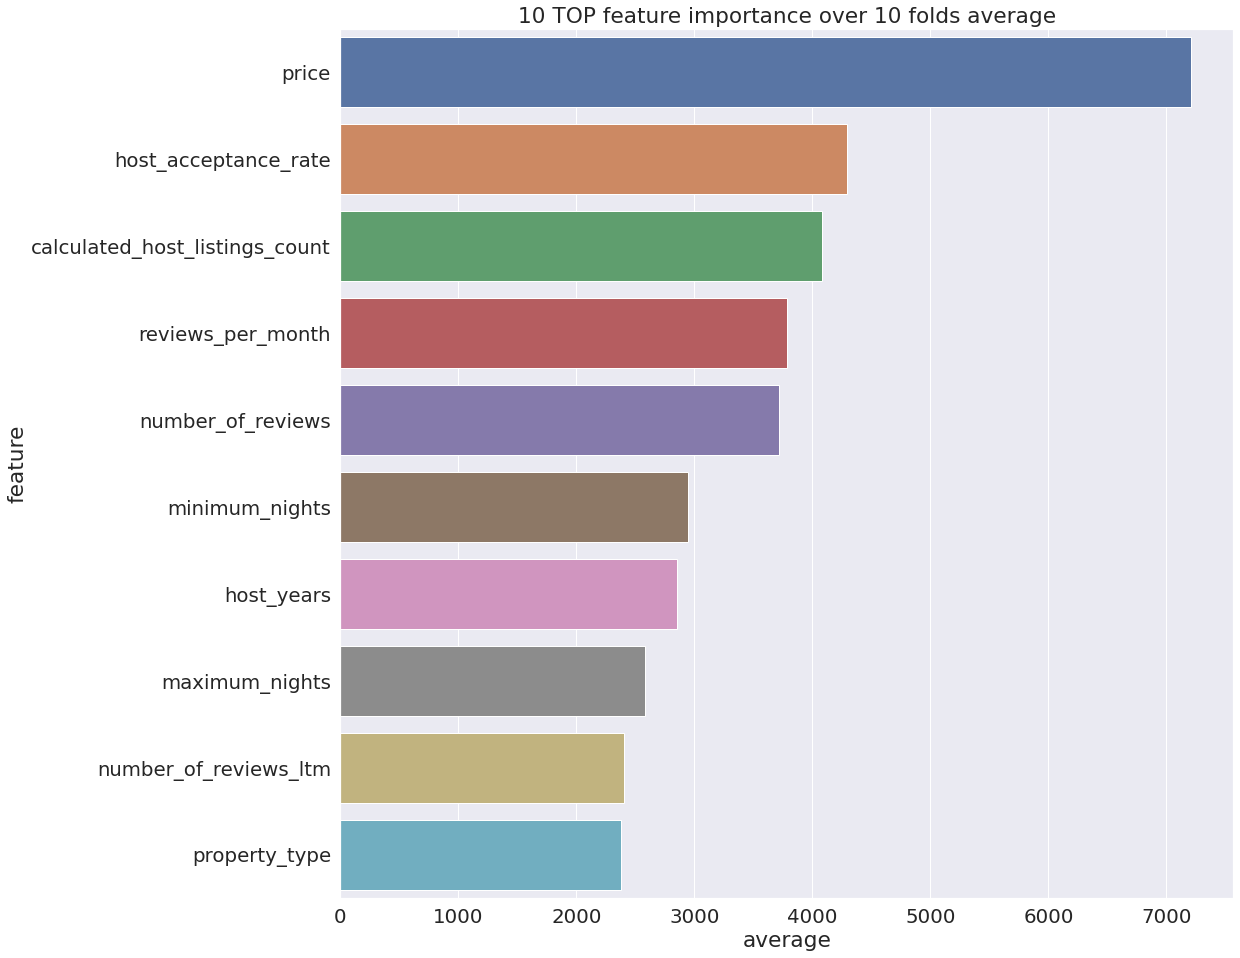

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)

sns.set(font_scale=1.8)
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(10), x='average', y='feature');
plt.title('10 TOP feature importance over {} folds average'.format(folds.n_splits));

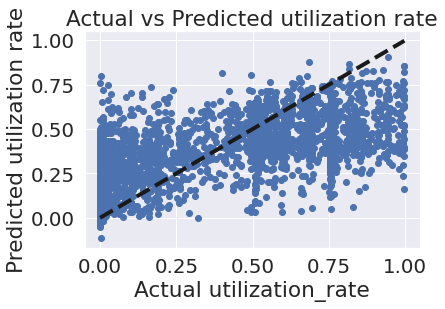

In [14]:
fig, ax = plt.subplots()
ax.scatter(y_proc, y_oof);
ax.plot([y_proc.min(), y_proc.max()], [y_proc.min(), y_proc.max()], 'k--', lw=4)
ax.set_xlabel('Actual utilization_rate')
ax.set_ylabel('Predicted utilization rate')
plt.title("Actual vs Predicted utilization rate")
plt.show()

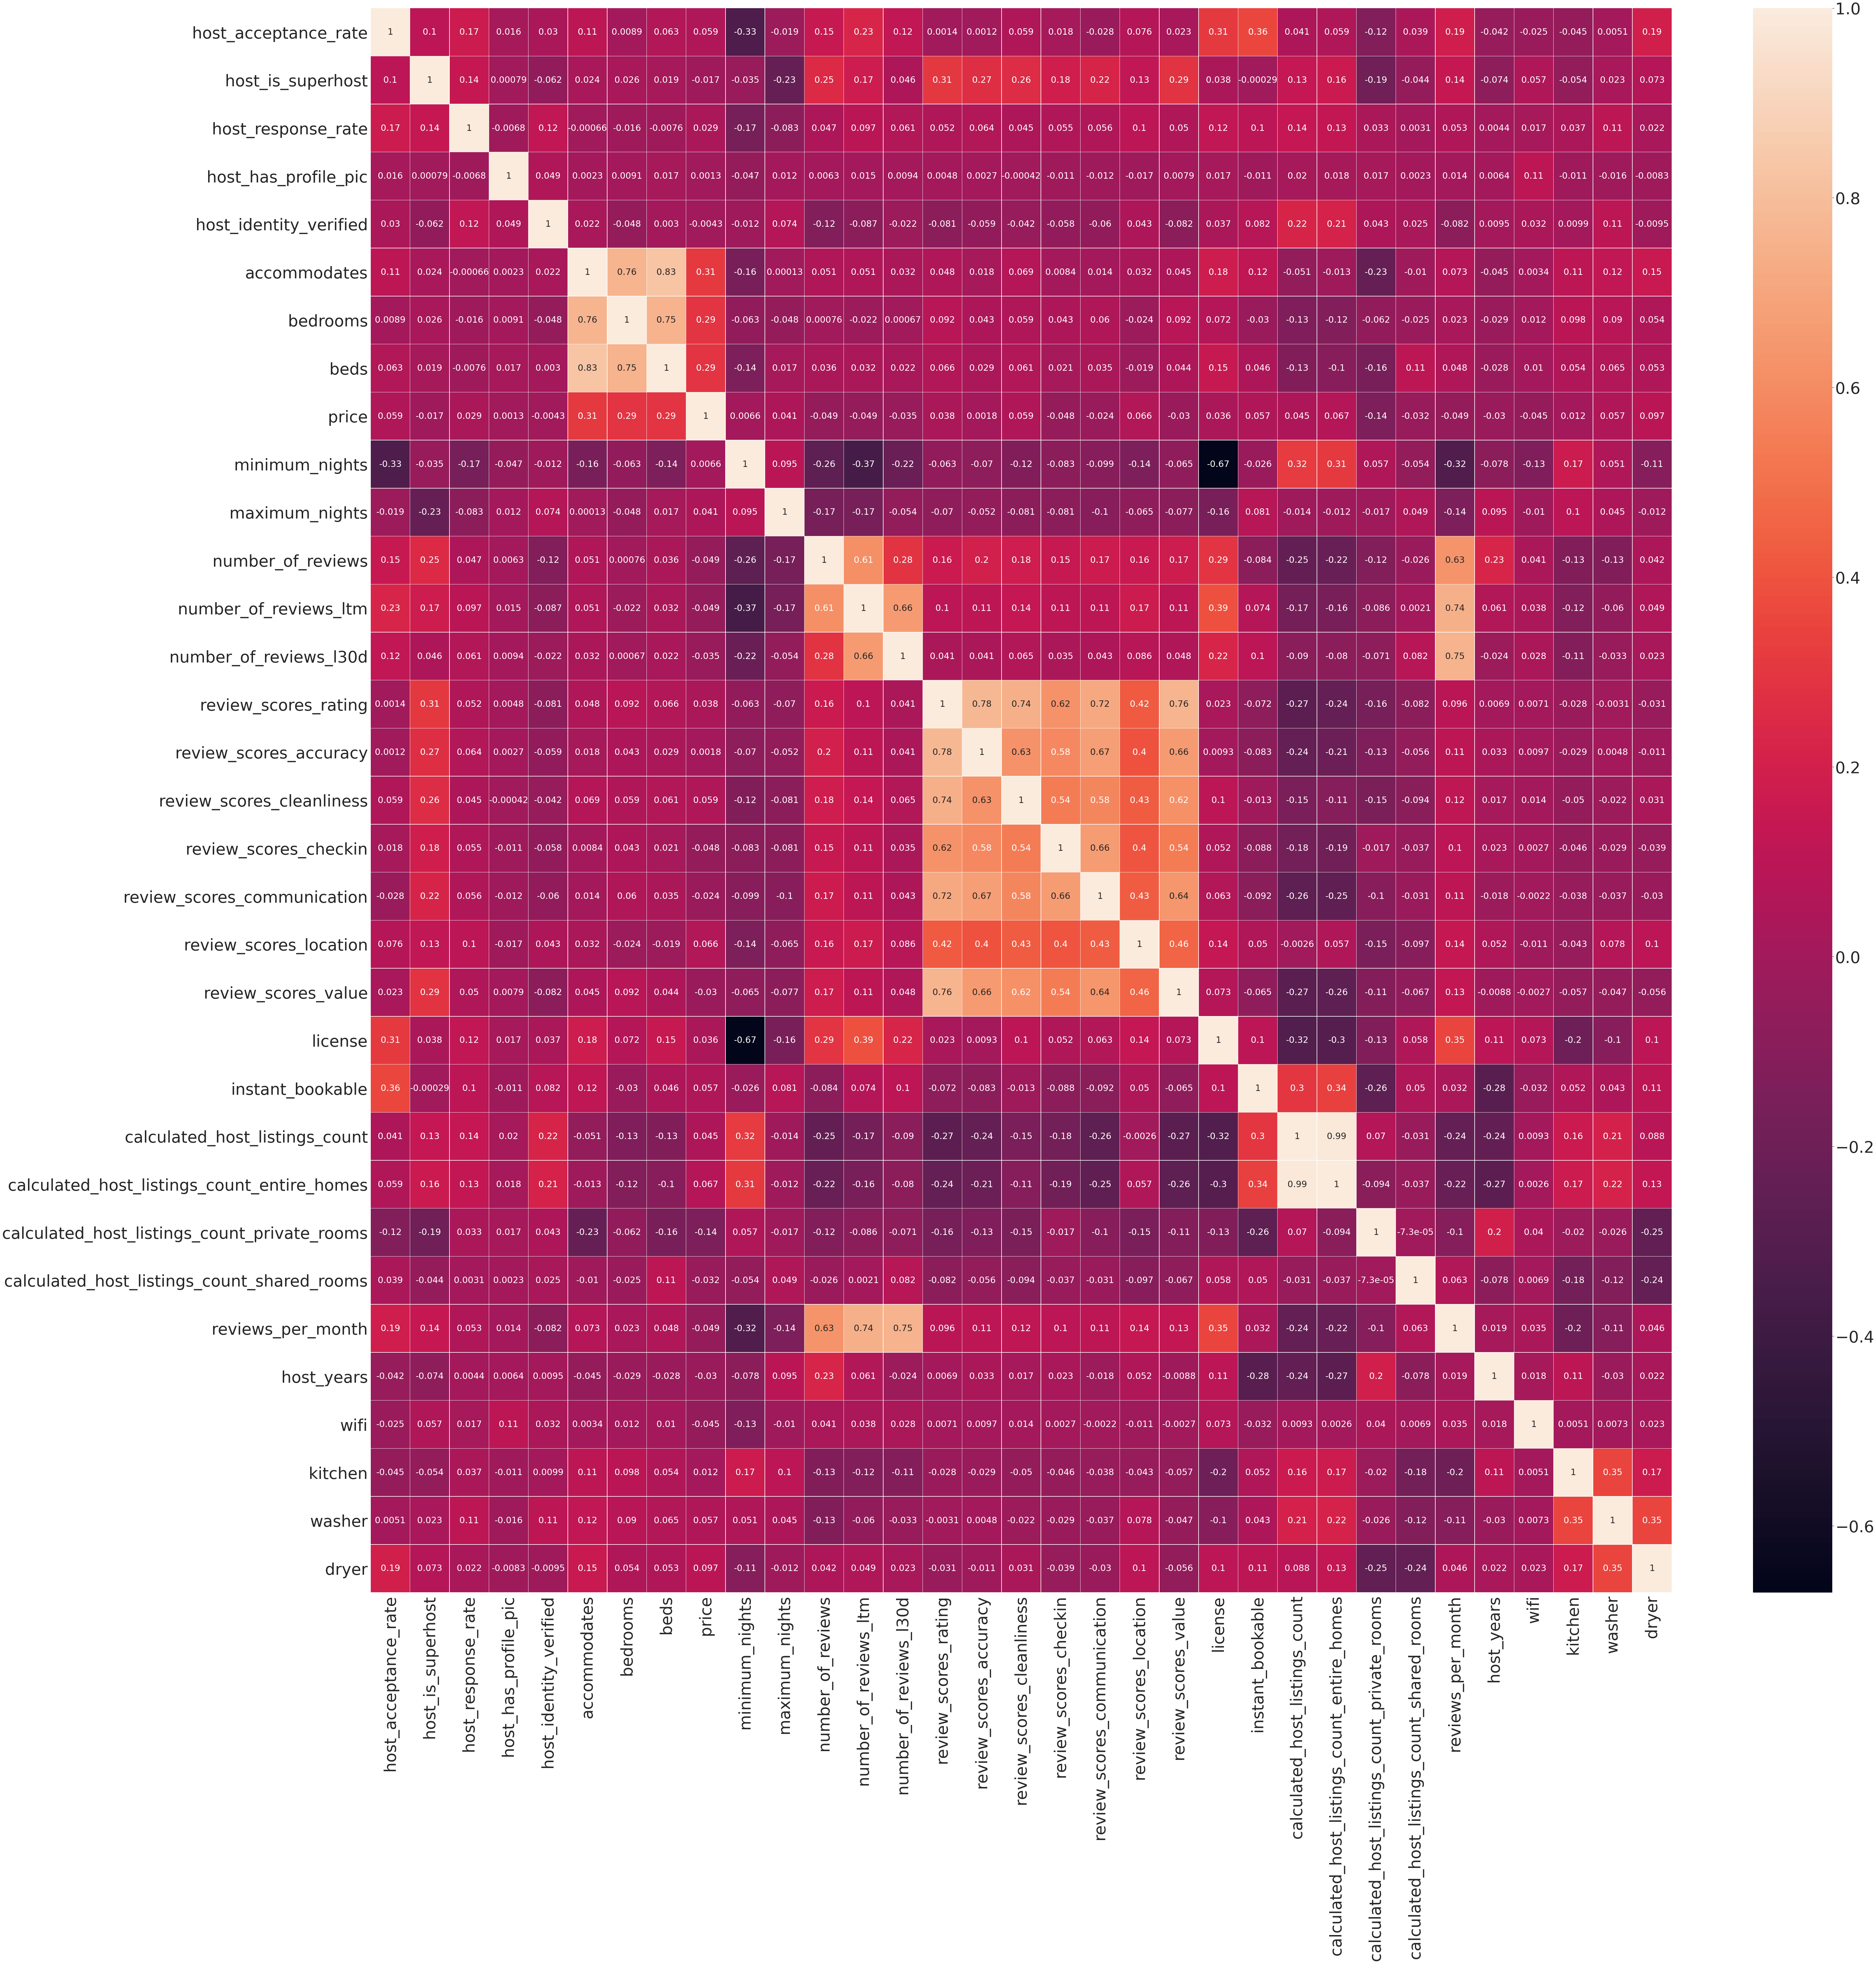

In [15]:
vis_x = x_proc.copy()
corr = vis_x.corr()
sns.set(font_scale=5)
plt.figure(figsize=(100,100))
sns.heatmap(corr,linewidths=0.5,annot=True, annot_kws={"size": 30});